In [1]:
# !pip install torch transformers scikit-learn pandas pyarrow fastparquet matplotlib

In [ ]:
# Import libraries
# =============================================================================
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from transformers import AutoTokenizer, DataCollatorWithPadding, DistilBertModel

import matplotlib.pyplot as plt

# Training parameters

In [ ]:
# Configuration
# ====================

MODEL_NAME = "distilbert-base-uncased"

SAVE_PATH = "../models/distilbert_finetuned.pth"  #

DATASET_PATH = "../data/processed/" #
MAX_LENGTH = 300
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
LOGGING_STEPS = 100
DROPOUT = 0.1
THRESHOLD = 0.4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gamma=1.5

# Dataloader Pytorch

In [ ]:
# This class defines a PyTorch Dataset that loads toxic comments from a Parquet file, tokenizes each comment,
# and returns the tokenized text together with its multilabel toxicity targets, ready to be used in a DataLoader for training or evaluation.
# =============================================================================

class ToxicCommentsDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length):
        self.dataframe = pd.read_parquet(data_path)
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.label_cols = [
            'toxic', 'severe_toxic', 'obscene',
            'threat', 'insult', 'identity_hate'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.loc[idx, 'text_light']

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_tensors=None
        )

        labels = labels = (
            self.dataframe
            .loc[idx, self.label_cols]
            .astype(float)    
            .values
        )

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            # 'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float32)
        }

# Data paths

In [ ]:
# Path definitions
# =============================================================================

train_path = os.path.join(DATASET_PATH, 'train_cleaned.parquet')
val_path = os.path.join(DATASET_PATH, 'valid_cleaned.parquet')
test_path = os.path.join(DATASET_PATH, 'test_cleaned.parquet')

# Finetuning functions

In [ ]:
# FocalLoss: Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
# =============================================================================

class FocalLossWithLogits(nn.Module):
    """
    Multilabel Focal Loss computed from logits.

    FL = - [ alpha * (1 - p)^gamma * log(p) * y
           + (1 - alpha) * p^gamma * log(1 - p) * (1 - y) ]

    where p = sigmoid(logits)
    """

    def __init__(
        self,
        alpha: torch.Tensor,   # shape (K,)
        gamma: float = 2.0,
        reduction: str = "mean",
    ):
        super().__init__()

        if alpha.dim() != 1:
            raise ValueError("alpha must be a 1D tensor of shape (K,)")

        self.register_buffer("alpha", alpha)
        self.gamma = gamma
        self.reduction = reduction

    def forward(
        self,
        logits: torch.Tensor,  # (N, K)
        targets: torch.Tensor # (N, K) in {0,1}
    ) -> torch.Tensor:

        targets = targets.float()

        # Probabilities
        p = torch.sigmoid(logits)

        # log-probabilities
        log_p = F.logsigmoid(logits)      # log(p)
        log_1mp = F.logsigmoid(-logits)   # log(1 - p)

        # Focal loss terms
        loss_pos = (
            self.alpha
            * (1.0 - p) ** self.gamma
            * log_p
            * targets
        )

        loss_neg = (
            (1.0 - self.alpha)
            * p ** self.gamma
            * log_1mp
            * (1.0 - targets)
        )

        loss = -(loss_pos + loss_neg)  # (N, K)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss



In [ ]:
# Multi-label classifier built on top of DistilBERT 
# =============================================================================

class DistilBertMultiLabelClassifier(nn.Module):
    def __init__(self, distilbert, num_labels, dropout, alpha, gamma):
        super().__init__()

        self.distilbert = distilbert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(
            distilbert.config.hidden_size,
            num_labels
        )
        self.criterion = FocalLossWithLogits(alpha, gamma)

    def forward(self, input_ids,attention_mask, labels=None):  #
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # CLS token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        logits = self.classifier(self.dropout(cls_embedding))

        loss = None
        if labels is not None:
            loss = self.criterion(logits, labels)

        return {"loss": loss, "logits": logits}

In [ ]:
# Function to find the best threshold per label (by maximizing F1)
# =====================================================
def find_best_thresholds(y_true, y_prob, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.7, 10)

    K = y_true.shape[1]
    best_thresholds = np.zeros(K)

    for k in range(K):
        best_f1 = -1.0
        best_t = 0.5

        for t in grid:
            preds = (y_prob[:, k] >= t).astype(int)
            f1 = f1_score(y_true[:, k], preds, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_t = t

        best_thresholds[k] = best_t

    return best_thresholds

# Configuration

In [9]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME)
distilbert = DistilBertModel.from_pretrained(pretrained_model_name_or_path=MODEL_NAME)

# Load datasets
train_dataset = ToxicCommentsDataset(train_path, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentsDataset(val_path, tokenizer, MAX_LENGTH)
test_dataset = ToxicCommentsDataset(test_path, tokenizer, MAX_LENGTH)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)


In [10]:
train_dataset.dataframe[train_dataset.label_cols].astype(float).mean()

toxic            0.096165
severe_toxic     0.010152
obscene          0.053057
threat           0.003063
insult           0.049406
identity_hate    0.008907
dtype: float64

In [ ]:
# Define the value of alpha for each label
# =====================================================

label_cols = train_dataset.label_cols

# Number of positive labels in each column
N_k = (
    train_dataset.dataframe[label_cols]
    .astype(float)
    .sum(axis=0)
    .values
)

# Normalisation 
N_max = N_k.max()
rho = N_k / N_max

# Normalized Alpha 
alpha = (1.0 - rho)
alpha = alpha / alpha.sum()

alpha = torch.tensor(alpha, dtype=torch.float32)

In [ ]:
# Initialize the model and the optimizer
model = DistilBertMultiLabelClassifier(distilbert=distilbert, num_labels=6, dropout=DROPOUT, alpha=alpha, gamma=gamma)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [13]:
print(next(model.parameters()).device)

cuda:0


In [ ]:
# Freeze all DistilBERT parameters
for param in distilbert.parameters():
    param.requires_grad = False

# Defreeze the last two layers of Distilbert
for layer in distilbert.transformer.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Training and validation

In [ ]:
# Tracking variables
# =====================================================
best_val_f1 = -np.inf
best_epoch = -1
best_thresholds = None

history = {
    "epoch": [],
    "train_loss": [],
    "val_acc": [],
    "val_f1_macro": [],
    "val_f1_micro": [],
    "val_f1_weighted": [],
    "is_best": []
}


# Training loop
# =====================================================
for epoch in range(NUM_EPOCHS):

    # =====================
    # TRAIN
    # =====================
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )

        loss = outputs["loss"]
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # =====================
    # VALIDATION
    # =====================
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )

            probs = torch.sigmoid(outputs["logits"])

            all_probs.append(probs.cpu())
            all_labels.append(batch["labels"].cpu())

    all_probs = torch.cat(all_probs).numpy()    # (N, K)
    all_labels = torch.cat(all_labels).numpy()  # (N, K)

    # =====================
    # Threshold optimization
    # =====================
    thresholds = find_best_thresholds(all_labels, all_probs)

    preds = (all_probs >= thresholds).astype(int)

    val_acc = accuracy_score(all_labels, preds)
    val_f1_macro = f1_score(all_labels, preds, average="macro", zero_division=0)
    val_f1_micro = f1_score(all_labels, preds, average="micro", zero_division=0)
    val_f1_weighted = f1_score(all_labels, preds, average="weighted", zero_division=0)

    # =====================
    # Best model tracking
    # =====================
    is_best = False
    if val_f1_weighted > best_val_f1:
        best_val_f1 = val_f1_weighted
        best_epoch = epoch
        best_thresholds = thresholds
        is_best = True

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "thresholds": best_thresholds,
                "val_f1_macro": val_f1_macro,
                "val_f1_micro": val_f1_micro,
                "val_f1_weighted": val_f1_weighted,
                "best_thresholds" : thresholds
            },
            SAVE_PATH
        )

        print(f"New best model saved (epoch {epoch+1}, F1_weighted={val_f1_weighted:.4f}, best_thresholds = {thresholds})")

    # =====================
    # Store history
    # =====================
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1_macro"].append(val_f1_macro)
    history["val_f1_micro"].append(val_f1_micro)
    history["val_f1_weighted"].append(val_f1_weighted)
    history["is_best"].append(is_best)

    # =====================
    # Logging
    # =====================
    print(
        f"Epoch {epoch+1} | "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"F1 macro: {val_f1_macro:.4f} | "
        f"F1 micro: {val_f1_micro:.4f} | "
        f"Best F1 (weighted): {best_val_f1:.4f}"
    )

print(f"\n Best model at epoch {best_epoch+1} with F1_weighted = {best_val_f1:.4f}")

New best model saved (epoch 1, F1_weighted=0.6103, best_thresholds = [0.05       0.33888889 0.26666667 0.19444444 0.26666667 0.26666667])
Epoch 1 | Train loss: 0.0051 | Val Acc: 0.9083 | F1 macro: 0.5504 | F1 micro: 0.6333 | Best F1 (weighted): 0.6103
New best model saved (epoch 2, F1_weighted=0.6238, best_thresholds = [0.05       0.26666667 0.26666667 0.19444444 0.26666667 0.26666667])
Epoch 2 | Train loss: 0.0031 | Val Acc: 0.9114 | F1 macro: 0.5882 | F1 micro: 0.6484 | Best F1 (weighted): 0.6238
Epoch 3 | Train loss: 0.0029 | Val Acc: 0.9090 | F1 macro: 0.5888 | F1 micro: 0.6382 | Best F1 (weighted): 0.6238
Epoch 4 | Train loss: 0.0027 | Val Acc: 0.9098 | F1 macro: 0.5786 | F1 micro: 0.6349 | Best F1 (weighted): 0.6238
Epoch 5 | Train loss: 0.0025 | Val Acc: 0.9104 | F1 macro: 0.5826 | F1 micro: 0.6428 | Best F1 (weighted): 0.6238
Epoch 6 | Train loss: 0.0022 | Val Acc: 0.9057 | F1 macro: 0.5636 | F1 micro: 0.6098 | Best F1 (weighted): 0.6238
Epoch 7 | Train loss: 0.0020 | Val Acc: 

# Test set

/tmp/ipykernel_2555/2245037036.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_PATH, map_location=device)


Loaded best model from epoch: 2
Best thresholds per label: [0.05       0.26666667 0.26666667 0.19444444 0.26666667 0.26666667]


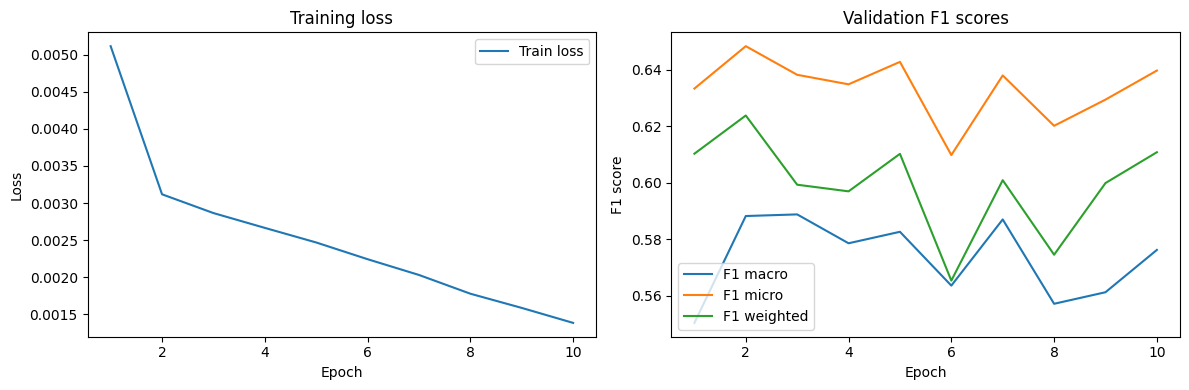


===== TEST SET METRICS =====
Accuracy       : 0.9054
F1 macro       : 0.5858
F1 micro       : 0.6360
F1 weighted    : 0.6066


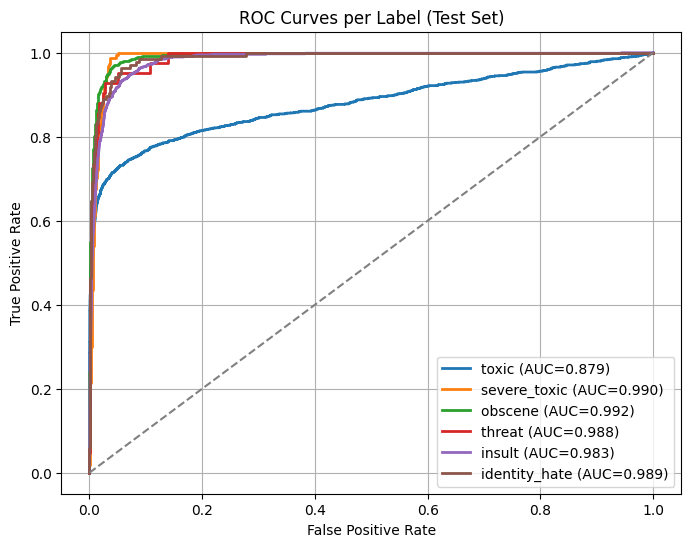

In [ ]:

# Load best model + thresholds
# =====================================================
checkpoint = torch.load(SAVE_PATH, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

best_thresholds = checkpoint["best_thresholds"]
thresholds = torch.tensor(best_thresholds).to(device)

print("Loaded best model from epoch:", checkpoint["epoch"] + 1)
print("Best thresholds per label:", best_thresholds)


# Plot training history
# =====================================================
epochs = history["epoch"]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["val_f1_macro"], label="F1 macro")
plt.plot(epochs, history["val_f1_micro"], label="F1 micro")
plt.plot(epochs, history["val_f1_weighted"], label="F1 weighted")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Validation F1 scores")
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate on TEST set
# =====================================================
all_probs_test, all_labels_test = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        probs = torch.sigmoid(outputs["logits"])

        all_probs_test.append(probs.cpu())
        all_labels_test.append(batch["labels"].cpu())

all_probs_test = torch.cat(all_probs_test).numpy()    # (N, K)
all_labels_test = torch.cat(all_labels_test).numpy()  # (N, K)

preds_test = (all_probs_test >= best_thresholds).astype(int)

test_acc = accuracy_score(all_labels_test, preds_test)
test_f1_macro = f1_score(all_labels_test, preds_test, average="macro", zero_division=0)
test_f1_micro = f1_score(all_labels_test, preds_test, average="micro", zero_division=0)
test_f1_weighted = f1_score(all_labels_test, preds_test, average="weighted", zero_division=0)

print("\n===== TEST SET METRICS =====")
print(f"Accuracy       : {test_acc:.4f}")
print(f"F1 macro       : {test_f1_macro:.4f}")
print(f"F1 micro       : {test_f1_micro:.4f}")
print(f"F1 weighted    : {test_f1_weighted:.4f}")


# ROC AUC curves (one per label)
# =====================================================
plt.figure(figsize=(8, 6))

for k, label_name in enumerate(train_dataset.label_cols):
    if all_labels_test[:, k].sum() == 0:
        print(f"Skipping ROC for {label_name} (no positive samples)")
        continue

    fpr, tpr, _ = roc_curve(all_labels_test[:, k], all_probs_test[:, k])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{label_name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Label (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
